# **LGB**

In [2]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

df_lgb = pd.read_csv('/content/drive/MyDrive/engineered_features_tree.csv')

In [3]:
df_lgb.drop(columns=['promo_interval'], inplace=True)

In [21]:
df_lgb = df_lgb.sort_values(['store_id','date_id'])

# ==== 1. Define split dates ====
train_cutoff = '2015-04-30'  # training data ends here
val_cutoff   = '2015-06-15'  # validation data ends here
test_cutoff  = '2015-07-31'  # final test ends here

# ==== 2. Create splits ====
train_df = df_lgb[df_lgb['date_id'] < train_cutoff]
val_df   = df_lgb[(df_lgb['date_id'] >= train_cutoff) & (df_lgb['date_id'] < val_cutoff)]
test_df  = df_lgb[(df_lgb['date_id'] >= val_cutoff) & (df_lgb['date_id'] < test_cutoff)]

# ==== 3. Prepare features ====
target_col = 'sales'
drop_cols  = ['sales', 'date_id']  # drop target + date

X_train, y_train = train_df.drop(columns=drop_cols), train_df[target_col]
X_val, y_val     = val_df.drop(columns=drop_cols), val_df[target_col]
X_test, y_test   = test_df.drop(columns=drop_cols), test_df[target_col]

# ==== 4. LightGBM datasets ====
train_set = lgb.Dataset(X_train, label=y_train)
val_set   = lgb.Dataset(X_val, label=y_val, reference=train_set)

# ==== 5. Train model ====
model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    learning_rate=0.05,
    num_leaves=64,
    random_state=42,
    n_estimators=4000
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=100)
    ]
)

y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_val)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.201532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 913514, number of used features: 31
[LightGBM] [Info] Start training from score 5750.347439
Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 899.791	val's rmse: 1014.54
[200]	train's rmse: 801.596	val's rmse: 927.988
[300]	train's rmse: 758.153	val's rmse: 908.792
[400]	train's rmse: 726.033	val's rmse: 887.975
[500]	train's rmse: 702.871	val's rmse: 883.843
[600]	train's rmse: 682.418	val's rmse: 879.409
[700]	train's rmse: 666.458	val's rmse: 871.004
[800]	train's rmse: 652.629	val's rmse: 866.201
[900]	train's rmse: 640.379	val's rmse: 861.094
[1000]	train's rmse: 630.701	val's rmse: 857.982
[1100]	train's rmse: 621.314	val's rmse: 854.30

In [22]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_test)

# Safe RMSPE
def rmspe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0   # avoid division by zero
    return np.sqrt(np.mean(np.square((y_true[mask] - y_pred[mask]) / y_true[mask]))) * 100

rmspe_val = rmspe(y_test, y_pred_test)

print(f"MAE LGBM: {mae}")
print(f"RMSPE LGBM: {rmspe_val}%")


MAE LGBM: 603.5796986587301
RMSPE LGBM: 15.022321626825669%


In [ ]:
import joblib
joblib.dump(model, "lgbm_sales_forecast.pkl")

['lgbm_sales_forecast.pkl']

In [ ]:
!cp /content/lgbm_sales_forecast.pkl /content/drive/MyDrive/

In [ ]:
import joblib
model = joblib.load("lgbm_sales_forecast.pkl")

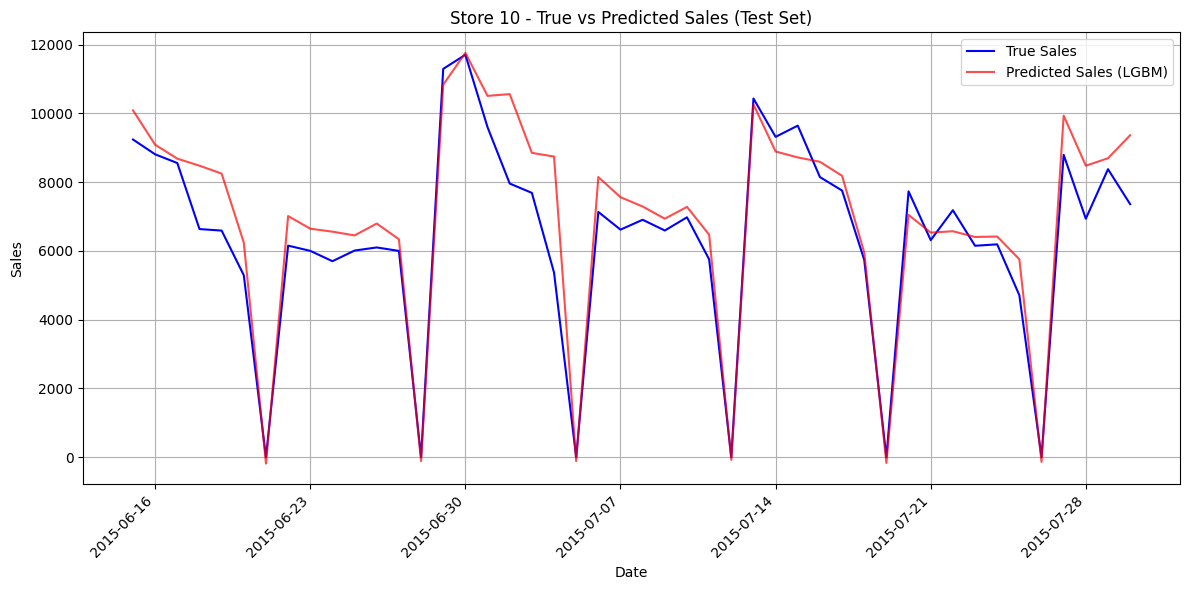

In [26]:
import matplotlib.pyplot as plt

# Predict using best iteration
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration_)

# Add predictions to the test dataframe for plotting
plot_df = test_df.copy()
plot_df['predicted_sales'] = y_pred_test

store = 10

store_df = plot_df[plot_df['store_id'] == store].sort_values('date_id').copy()
store_df['date_id'] = pd.to_datetime(store_df['date_id'])

plt.figure(figsize=(12, 6))
plt.plot(store_df['date_id'], store_df['sales'], label='True Sales', color='blue')
plt.plot(store_df['date_id'], store_df['predicted_sales'], label='Predicted Sales (LGBM)', color='red', alpha=0.7)

plt.title(f"Store {store} - True vs Predicted Sales (Test Set)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


# **XGB**

In [11]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# ==== 1. Prepare DMatrix for XGBoost ====
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

# ==== 2. XGBoost parameters ====
params_xgb = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# ==== 3. Train XGBoost with early stopping ====
evals = [(dtrain, 'train'), (dval, 'val')]
model_xgb = xgb.train(
    params=params_xgb,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=200,
    verbose_eval=100
)

# ==== 4. Evaluate ====
y_pred_val_xgb  = model_xgb.predict(dval, iteration_range=(0, model_xgb.best_iteration))
y_pred_test_xgb = model_xgb.predict(dtest, iteration_range=(0, model_xgb.best_iteration))

val_rmse_xgb  = np.sqrt(mean_squared_error(y_val, y_pred_val_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))

print(f"XGBoost Best Iteration: {model_xgb.best_iteration}")
print(f"XGBoost Validation RMSE: {val_rmse_xgb:.2f}")
print(f"XGBoost Test RMSE: {test_rmse_xgb:.2f}")


[0]	train-rmse:3680.07868	val-rmse:3936.86934
[100]	train-rmse:874.65568	val-rmse:997.14748
[200]	train-rmse:764.84683	val-rmse:911.96384
[300]	train-rmse:710.95200	val-rmse:880.11387
[400]	train-rmse:673.40939	val-rmse:864.37329
[500]	train-rmse:644.93302	val-rmse:856.27903
[600]	train-rmse:622.79956	val-rmse:852.22337
[700]	train-rmse:604.86604	val-rmse:851.14729
[800]	train-rmse:588.27879	val-rmse:848.21109
[900]	train-rmse:574.63695	val-rmse:849.07040
[1000]	train-rmse:562.63216	val-rmse:851.51610
[1051]	train-rmse:556.99133	val-rmse:850.74215
XGBoost Best Iteration: 852
XGBoost Validation RMSE: 847.40
XGBoost Test RMSE: 893.55


In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_test)

# Safe RMSPE
def rmspe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0   # avoid division by zero
    return np.sqrt(np.mean(np.square((y_true[mask] - y_pred[mask]) / y_true[mask]))) * 100

rmspe_val = rmspe(y_test, y_pred_test_xgb)

print(f"MAE XGBM: {mae}")
print(f"RMSPE XGBM: {rmspe_val}%")

MAE XGBM: 603.5796986587301
RMSPE XGBM: 13.948759248145146%


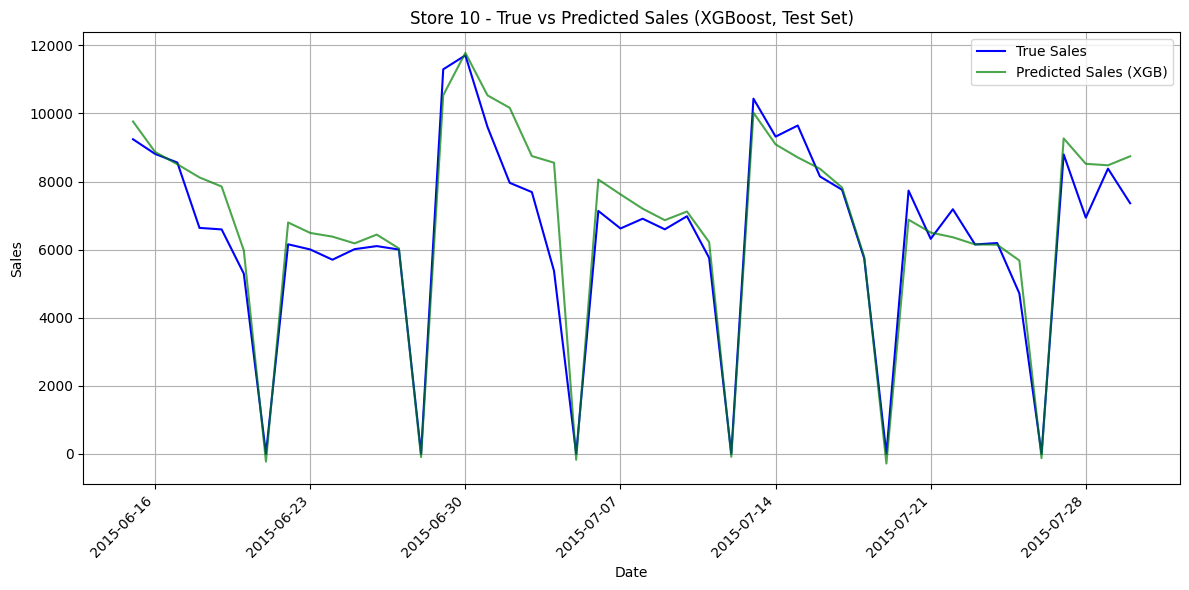

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Predict using best iteration from XGBoost
y_pred_test_xgb = model_xgb.predict(
    xgb.DMatrix(X_test),
    iteration_range=(0, model_xgb.best_iteration)
)

# Add predictions to the test dataframe for plotting
plot_df_xgb = test_df.copy()
plot_df_xgb['predicted_sales_xgb'] = y_pred_test_xgb

store = 10
store_df_xgb = plot_df_xgb[plot_df_xgb['store_id'] == store].sort_values('date_id')

store_df_xgb['date_id'] = pd.to_datetime(store_df_xgb['date_id'])

plt.figure(figsize=(12, 6))
plt.plot(store_df_xgb['date_id'], store_df_xgb['sales'], label='True Sales', color='blue')
plt.plot(store_df_xgb['date_id'], store_df_xgb['predicted_sales_xgb'], label='Predicted Sales (XGB)', color='green', alpha=0.7)

plt.title(f"Store {store} - True vs Predicted Sales (XGBoost, Test Set)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
model_xgb.save_model("xgb_sales_forecast.json")

In [ ]:
!cp /content/xgb_sales_forecast.json /content/drive/MyDrive/

In [ ]:
import xgboost as xgb

# Load from saved file
model_xgb = xgb.Booster()
model_xgb.load_model("xgb_sales_forecast.json")

# **Models Evaluation**

,store_type,model,RMSE,MAE,n_stores
0,a,LightGBM,952.810052,595.495110,602
1,a,XGBoost,917.777615,573.830688,602
2,b,LightGBM,1184.283218,874.564740,17
3,b,XGBoost,1205.765524,900.180603,17
4,c,LightGBM,906.544636,614.989638,148
5,c,XGBoost,861.587815,598.439941,148
6,d,LightGBM,887.864450,599.474830,348
7,d,XGBoost,845.200383,586.729858,348


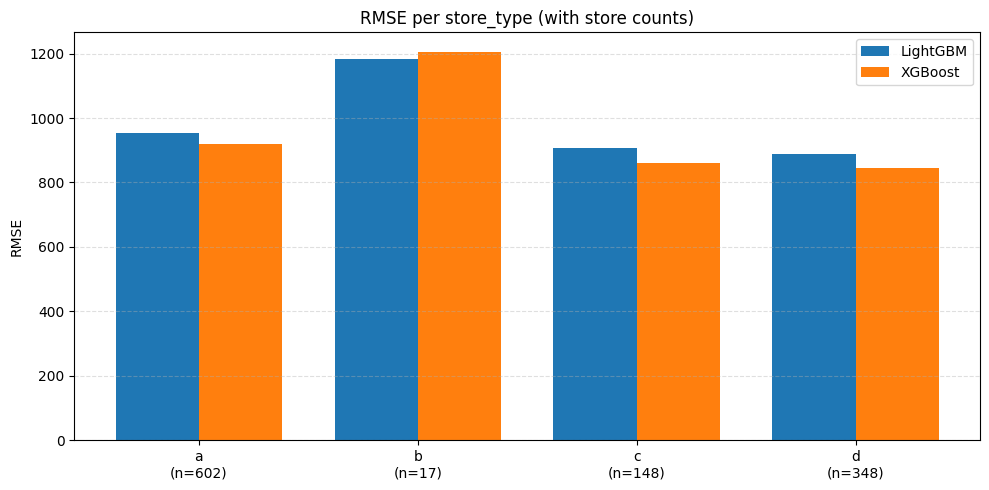

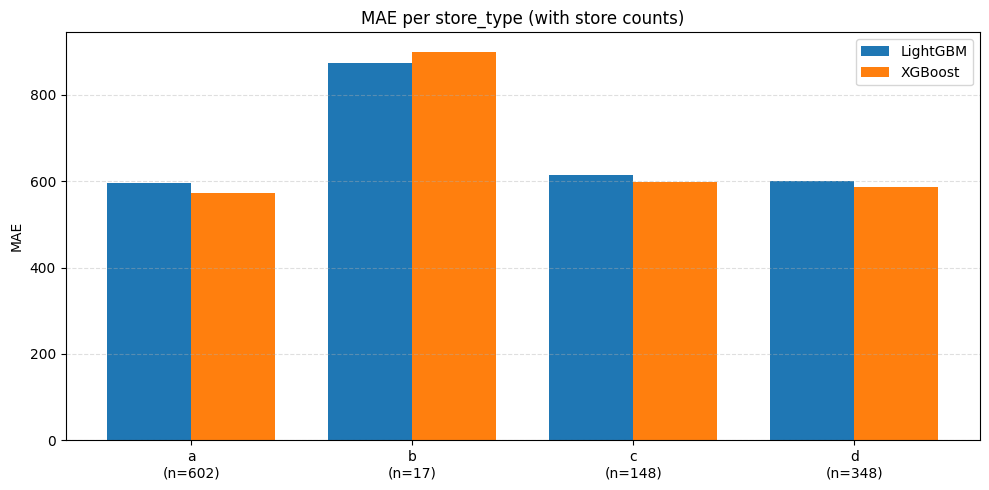

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

store_type_map = {0: "a", 1: "b", 2: "c", 3: "d"}

plot_df = pd.DataFrame({
    "store_type": X_test["store_type"].map(store_type_map).values,
    "store_id": X_test["store_id"].values,
    "sales": np.asarray(y_test),
    "pred_lgb": np.asarray(y_pred_test),
    "pred_xgb": np.asarray(y_pred_test_xgb),
})

plot_df["store_type"] = plot_df["store_type"].astype(str)

rows = []
for st, g in plot_df.groupby("store_type"):
    y_true = g["sales"].values
    n_stores = g["store_id"].nunique()

    rows.append({
        "store_type": st, "model": "LightGBM",
        "RMSE": float(np.sqrt(mean_squared_error(y_true, g["pred_lgb"].values))),
        "MAE": float(mean_absolute_error(y_true, g["pred_lgb"].values)),
        "n_stores": n_stores
    })
    rows.append({
        "store_type": st, "model": "XGBoost",
        "RMSE": float(np.sqrt(mean_squared_error(y_true, g["pred_xgb"].values))),
        "MAE": float(mean_absolute_error(y_true, g["pred_xgb"].values)),
        "n_stores": n_stores
    })

metrics_df = pd.DataFrame(rows).sort_values(["store_type","model"]).reset_index(drop=True)
display(metrics_df)

# ---- Grouped bar plots (RMSE and MAE) ----
store_types = metrics_df["store_type"].unique().tolist()
models = ["LightGBM", "XGBoost"]
x = np.arange(len(store_types))
width = 0.38

# RMSE
fig_rmse, ax_rmse = plt.subplots(figsize=(10, 5))
for i, m in enumerate(models):
    vals = metrics_df.loc[metrics_df["model"]==m, :].set_index("store_type").loc[store_types, "RMSE"].values
    ax_rmse.bar(x + (i-0.5)*width, vals, width, label=m)
ax_rmse.set_xticks(x)
ax_rmse.set_xticklabels([f"{st}\n(n={metrics_df[metrics_df['store_type']==st]['n_stores'].iloc[0]})" for st in store_types])
ax_rmse.set_ylabel("RMSE")
ax_rmse.set_title("RMSE per store_type (with store counts)")
ax_rmse.legend()
ax_rmse.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# MAE
fig_mae, ax_mae = plt.subplots(figsize=(10, 5))
for i, m in enumerate(models):
    vals = metrics_df.loc[metrics_df["model"]==m, :].set_index("store_type").loc[store_types, "MAE"].values
    ax_mae.bar(x + (i-0.5)*width, vals, width, label=m)
ax_mae.set_xticks(x)
ax_mae.set_xticklabels([f"{st}\n(n={metrics_df[metrics_df['store_type']==st]['n_stores'].iloc[0]})" for st in store_types])
ax_mae.set_ylabel("MAE")
ax_mae.set_title("MAE per store_type (with store counts)")
ax_mae.legend()
ax_mae.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
